<a href="https://colab.research.google.com/github/TableASCII/Student_Assistance_RAG_System/blob/main/create_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install docling
!pip install requests
!pip install spacy
!python -m spacy download ru_core_news_sm

In [ ]:
import numpy as np
import pandas as pd
from docling.document_converter import DocumentConverter
import requests
import re
from openai import OpenAI
import matplotlib.pyplot as plt
import spacy
from google.colab import files

## Подготовка датасета для RAG-системы

В качестве исходных данных для создания векторной базы знаний и обучения retrieval-модели был выбран "Путеводитель первокурсника" НГТУ им. Р.E. Алексеева.

Документ содержит структурированную информацию об университете, которая будет разбита на чанки для эффективного поиска релевантных ответов.

In [ ]:
source = "https://www.nntu.ru/frontend/web/ngtu/files/studentam/Putevoditel_pervokursnika_NNTU.pdf"

## Преобразование PDF в структурированный текст

Используем библиотеку Docling для конвертации PDF-документа в markdown-формат с сохранением структуры заголовков и таблиц.

In [ ]:
converter = DocumentConverter()
result = converter.convert(source)
text = result.document.export_to_markdown()

Фрагмент обработанного документа:

In [ ]:
print(text[48:521])

<!-- image -->

<!-- image -->

## Гимн НГТУ им. Р.Е. Алексеева

Слова Владимира Дубинского, Юрия Адясова, Владимира Карпея Музыка Николая Суворова

Стоишь ты гордо над рекою, Из вузов наших старше всех. Своей любви к тебе не скрою, Нижегородский Политех.

На первый курс пришел подростком. Все было: слезы и успех, Но найти призвание непросто, Нижегородский Политех.

Я сопромат зубрил до ночи, Не позабыть мне формул тех. Я инженер, ведь я закончил Нижегородский Политех.


##Деление документа на семантические блоки
Из текста удаляем блоки изображений (так как docling их не обрабатывает) и делим документ на более мелкие фрагменты - чанки, используя заголовки как разделитель (символ "##").

После первичного разделения фильтруем полученные чанки: оставляем только те, у которых не пустые заголовок и содержание.

In [ ]:
text = re.sub(r'<!-- image -->\s*(\n\s*\n)*', '', text) #удаление блоков картинок
chunks = re.split(r'\n##\s+', text)                     #деление текста на чанки по символу ##

# Удаление пустых абзацев
filtered_chunks = []
for chunk in chunks:
    chunk = chunk.strip()
    if not chunk:                                       # пропускаем пустые строки
        continue
    parts = chunk.split('\n', 1)                        #делим чанк на заголовок и содержание
    if len(parts) == 2:
        header, content = parts
        if header.strip() and content.strip():          #заголовок и содержимое не пустые
            filtered_chunks.append(chunk)

##Исключение слишком больших чанков
После того, как мы получили набор чанков, нужно исключить из него чрезмерно большие фрагменты.

Для этого создадим функцию для подсчета предложений в чанке. Чтобы разбиение на предложения было более точным - будем использовать SpaCy.

In [ ]:
nlp = spacy.load("ru_core_news_sm")                                           #загрузка модели для русского языка

ABBREVIATIONS = ['ул', 'пр', 'пер', 'ауд', 'им', 'г', 'д', 'т', 'рис', 'см',  #список основных сокращений
                 'vk', 'https', 'http', 'www', 'зам', 'общ', 'каб']
DOMAINS = ['com']

def split_into_sentences(text):
    text = re.sub(                                                            #заменяем все точки после аббревиатур на <dot>,
        r'\b(' + '|'.join(ABBREVIATIONS) + r')\.',                            #для корректного разделения текста на предложения
        r'\1<dot>',
        text,
        flags=re.IGNORECASE
    )
    text = re.sub(
        r'\.(' + '|'.join(DOMAINS) + r')\b',
        r'<dot>\1',
        text
    )

    # Разделение на предложения с помощью spaCy
    doc = nlp(text)                                                         #обработанный с помощью spaCy документ
    sentences = [sent.text.strip() for sent in doc.sents]                   #doc.sents - текст, разделенный на предложения

    sentences = [s.replace('<dot>', '.') for s in sentences]                # возврат точек в исходное состояние "."


    return sentences

Разделим данные на выбросы и все остальное. Выбросами будут считаться чанки, которые больше 4000 символов, к таким чанкам, например, относится содержание путеводителя.

In [ ]:
outliers = []
chunks_without_outliars = []

for chunk in filtered_chunks:
    if len(chunk) > 4000:
        outliers.append(chunk)
    else:
        chunks_without_outliars.append(chunk)

In [ ]:
#Список выбросов: фрагменты на 4000+ символов
for i, p in enumerate(outliers):
    print(f"\n--- Параграф {i} (длина: {len(p)} символов) ---\n")
    print(p)

Одним из больших фрагментов оказался абзац с полезными телефонами. Это важная информация, поэтому обработаем этот чанк особым образом.

In [ ]:
phones = ' '.join(map(str, outliers[:-1])) #берем все элементы массива выбросов кроме последнего, так как это все номера телефонов, а последний - содержание

Делаем каждый телефон отдельным чанком




In [ ]:
strs = phones.strip().split('\n')
phone_chunks = []
extra_text = ''                                                                 # текст названия института или другого подразделения помимо должности
mode = 'normal'                                                                 # режим работы: 'normal' - записи до чанка "Студенческий городок",
                                                                                # режим работы 'campus' нужен чтоб правильно обрабатывать записи в чанке "Студ. городок", так как там немного неправильно распарсилось
#записи формата | Ректор | Дмитриев Сергей Михайлович | 436-23-25|
for strr in strs:
    strr = strr.strip('|').strip()                                              #удаляем по краям в строке '|' и пробелы
    parts = [part.strip() for part in strr.split('|')]                          #разделяем строку на части по знаку '|'

    if len(parts) >= 3:
        clean_part0 = re.sub(r'[-\s]', '', parts[0])                            #чтоб не было записей состоящих из "---"
        clean_part1 = re.sub(r'[-\s]', '', parts[1])
        clean_part2 = re.sub(r'[-\s]', '', parts[2])
        if "Студенческий городок" in strr:                                      #если в тексте встретился чанк "Студенческий городок" - меняем режим обработки
                      extra_text = 'Студенческий городок' + ','
                      mode = 'campus'
        elif mode == 'normal':
            if (not clean_part0 and not clean_part2 and clean_part1):           #если текст только в средней части строки,
                extra_text = parts[1] + ','                                     #то строка - название института или подразделения в чанке Студ. городок
                mode = 'campus'
            elif (parts[0] == parts[1] == parts[2]) and clean_part0:            #если все 3 части одинаковые, то строка - это название института или подразделения
                extra_text = parts[1] + ','                                     #заносим название в  extra_text
            else:
                if all(re.sub(r'[-\s]', '', part) for part in parts[:3]):
                    chunk = f"Должность: {parts[0]}, {extra_text} ФИО: {parts[1]} , Номер телефона: {parts[2]}" #формируем чанк с телефоном
                    phone_chunks.append(chunk)
        else:                                                                   # режим 'campus'
            if (parts[0] == parts[1] == parts[2]) and clean_part0:
              extra_text = parts[1] + ','
              mode = 'normal'
            elif (not clean_part0 and not clean_part2 and clean_part1):
                extra_text = parts[1] + ','
            # В режиме "Студенческий городок" смотрим на пустые part0 и part2
            else:
              if all(re.sub(r'[-\s]', '', part) for part in parts[:3]):
                chunk = f"Должность: {parts[0]}, {extra_text} ФИО: {parts[1]} , Номер телефона: {parts[2]}"
                phone_chunks.append(chunk)

In [ ]:
for i, chunk in enumerate(phone_chunks):
    print(f"\n--- Параграф {i} (длина: {len(chunk)} символов) ---\n")
    print(chunk)

In [ ]:
chunks_without_outliars = chunks_without_outliars + phone_chunks #объединяем чанки с телефонами с остальными чанками

Считаем сколько в каждом чанке предложений:

In [ ]:
chunks_num_sentences = [len(split_into_sentences(chunk)) for chunk in chunks_without_outliars]

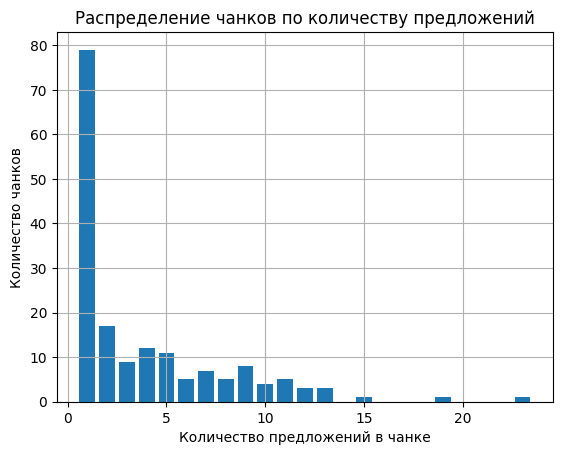

In [ ]:
plt.hist(chunks_num_sentences, bins=range(1, max(chunks_num_sentences)+2), align='left', rwidth=0.8)
plt.title("Распределение чанков по количеству предложений")
plt.xlabel("Количество предложений в чанке")
plt.ylabel("Количество чанков")
plt.grid(True)
plt.show()

In [ ]:
#Делим большие чанки на более мелкие
def split_long_chunk(chunk, chunk_size=2, max_chunk=4, min_chunk=2):
    sentences = split_into_sentences(chunk)                                     #список предложений чанка
    total = len(split_into_sentences(chunk))                                    #количество предложений в чанке

    if total < max_chunk:                                                       #если кол-во предложений в чанке меньше max_chunk, то оставляем чанк как есть,
        return [chunk]                                                          #он и так маленький

    chunks = []
    i = 0
    while i + chunk_size < total:
        chunks.append(sentences[i:i + chunk_size])                              #разделяем чанк на части равные chunk_size предложений
        i += chunk_size

    last_chunk = sentences[i:]

    if len(last_chunk) < min_chunk and chunks:                                  #если остаток от чанка небольшой (меньше чем min_chunk),
        chunks[-1].extend(last_chunk)                                           #то приклеиваем его к последней части
    else:
        chunks.append(last_chunk)                                               #если он больше или равен min_chunk
                                                                                #- делаем его отдельной частью
    result = [' '.join(chunk) for chunk in chunks]

    return result

In [ ]:
normalized_chunks = []  # сюда складываем результат

for chunk in chunks_without_outliars:
    parts = split_long_chunk(chunk)
    normalized_chunks.extend(parts)

Вывод нормализованных чанков:

In [ ]:
normalized_chunks_num_sentences = [split_into_sentences(chunk) for chunk in normalized_chunks]

(0.0, 11.0)

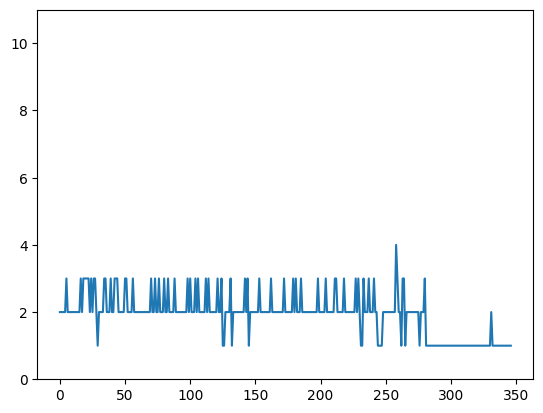

In [ ]:
plt.plot(normalized_chunks_num_sentences) #график количества предложений в чанке после деления больших чанков на части
plt.ylim(0, 11)

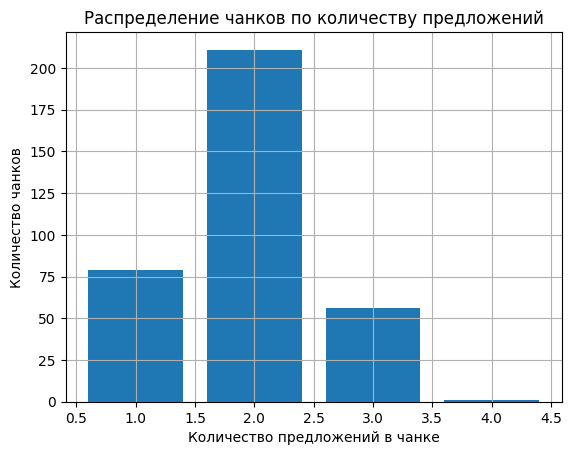

In [ ]:
plt.hist(normalized_chunks_num_sentences, bins=range(1, max(normalized_chunks_num_sentences)+2), align='left', rwidth=0.8)
plt.title("Распределение чанков по количеству предложений")
plt.xlabel("Количество предложений в чанке")
plt.ylabel("Количество чанков")
plt.grid(True)
plt.show()

##Отправка запросов к LLM и генерация вопросов к чанкам
Для обучения модели-ретривера необходим размеченный датасет вопрос-ответ. Мы создаем его синтетически, используя LLM. На этом этапе LLM генерирует релевантные вопросы, которые могут быть заданы к данному фрагменту текста.

Таким образом формируется датасет, на котором ретривер учится находить наиболее подходящие текстовые фрагменты в ответ на пользовательские запросы.


In [ ]:
from google.colab import userdata

In [ ]:
#инициализация клиентов опен роутер
client1 = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('API_KEY')
  )
client2 = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('API_KEY2')
  )
client3 = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('API_KEY3')
  )
client4 = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('API_KEY4')
  )
client5 = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('API_KEY5')
  )
client6 = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('API_KEY6')
  )
client7 = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=userdata.get('API_KEY7')
  )

In [ ]:
qa_pairs = [] #массив, куда будут заносится чанки + вопросы

In [ ]:
# Цикл по каждому абзацу

for i, para in enumerate(normalized_chunks):
    print(f"\n--- Обрабатывается абзац {i + 1} ---")

    # Подготовка промпта
    prompt = (f"""
    Задача:
    Сгенерируй пары вопросов (позитивный + негативный) на основе предоставленных данных. Ты генерируешь вопросы для поисковой системы НГТУ им. Алексеева.
    Формулируй вопросы без упоминания источников, данных или контекста.
    Если предоставленных данных мало, например, 1-2 предложения, придумай 2-3 вопроса.
    Если данных много (больше 2 предложений), придумай 3-4 вопроса, затрагивая основные аспекты из данных.

    Позитивные вопросы имеют ОДИН четкий ответ в данных, охватывают РАЗНЫЕ аспекты данных.
    Негативные вопросы должны быть ТЕМАТИЧЕСКИ СВЯЗАНЫ с данными, но:
   - Касаться аспектов, НЕ РАСКРЫТЫХ в данных, на которые нет ответа
   - Не должны быть перефразировкой позитивных вопросов
   - Не должны отличаться только одним словом или числом
    Формат строго:\n
    Позитивный 1: ...\n
    Негативный 1: ...\n
    Позитивный 2: ...\n
    Негативный 2: ...\n
    Позитивный 3: ...\n
    Негативный 3: ...\n
    Данные:\n{para}
    """
    )

    if i < 50:
        client = client1
    elif i < 100:
        client = client2
    elif i < 150:
        client = client3
    elif i < 200:
        client = client4
    elif i < 250:
        client = client5
    elif i < 300:
        client = client6
    elif i < 350:
        client = client7

    #отправка запроса
    try:
        completion = client.chat.completions.create(
            model="meta-llama/llama-4-maverick:free",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=1000
        )
    except Exception as e:
        print(f"Ошибка запроса: {e}")
        continue  # Пропустить итерацию при ошибке

    # Обработка ответа
    if completion and completion.choices:
        content = completion.choices[0].message.content
        print("Ответ от LLM:\n", content[:1200], "...\n")

        # Новая регулярка для захвата типа вопроса и текста
        matches = re.findall(
            r'(?i)(Позитивный|Негативный)\s*\d+[.:]?\s*(.*?)(?=\s*(?:Позитивный|Негативный)\s*\d|\Z)',
            content,
            re.DOTALL | re.IGNORECASE
        )

        if not matches:
            print("Не найдено вопросов для этого абзаца.")
        else:
            current_positive = None
            for q_type, question in matches:
                q_type = q_type.lower()
                cleaned_question = question.strip()

                # Группируем пары вопросов
                if q_type == 'позитивный':
                    current_positive = cleaned_question
                elif q_type == 'негативный' and current_positive:
                    qa_pairs.append({
                        "Абзац": para,
                        "Позитивный вопрос": current_positive,
                        "Негативный вопрос": cleaned_question
                    })
                    current_positive = None
    else:
        print("Ошибка: LLM не вернул ответ")

In [ ]:
# Создание датафрейма
df = pd.DataFrame(qa_pairs)
# Настройки для полного отображения
pd.set_option('display.max_rows', None)  # Показать все строки
pd.set_option('display.max_columns', None)  # Показать все столбцы
pd.set_option('display.width', None)  # Автоматическая ширина
pd.set_option('display.max_colwidth', None)  # Полный текст в ячейках
clean_df = df[ #удаление пустых строк из датафрейма
    ~df['Позитивный вопрос'].str.strip().eq("").fillna(False) &
    ~df['Негативный вопрос'].str.strip().eq("").fillna(False) &
    ~df['Позитивный вопрос'].str.strip().eq("...").fillna(False) &
    ~df['Негативный вопрос'].str.strip().eq("...").fillna(False)


].dropna( #удаление Nan
    subset=['Абзац', 'Позитивный вопрос', 'Негативный вопрос'],
    how='any'
).copy()

# Проверка результатов
print(f"Было строк: {len(df)}")
print(f"Стало строк: {len(clean_df)}")

display(clean_df)

Было строк: 6
Стало строк: 6


,Абзац,Позитивный вопрос,Негативный вопрос
0,"На первый курс пришел подростком, Все было - слезы и успех, Но найти призвание непросто, Нижегородский политех. Я сопромат зубрил до ночи, Не позабыть мне формул меx.",Какое учебное заведение упоминается в стихотворении?,Каковы были результаты студента после окончания университета?
1,"На первый курс пришел подростком, Все было - слезы и успех, Но найти призвание непросто, Нижегородский политех. Я сопромат зубрил до ночи, Не позабыть мне формул меx.",Какой предмет упоминается в стихотворении как зубрившийся до ночи?,Как студент проводил свое свободное время вне учебы?
2,"На первый курс пришел подростком, Все было - слезы и успех, Но найти призвание непросто, Нижегородский политех. Я сопромат зубрил до ночи, Не позабыть мне формул меx.",С каким эмоциональным состоянием ассоциируется приход на первый курс?,Какие конкретные формулы из области механики запомнил студент?
3,И бурлящий летний лагерь. Нижегородский политех.,Какое название носит политехнический институт в Нижнем Новгороде?,В каком году был основан политехнический институт в Нижнем Новгороде?
4,И бурлящий летний лагерь. Нижегородский политех.,Как можно описать атмосферу летнего лагеря?,Какие мероприятия проводятся в летнем лагере?
5,И бурлящий летний лагерь. Нижегородский политех.,Какое прилагательное используется для описания летнего лагеря?,Сколько человек обычно посещает летний лагерь?


In [ ]:
clean_df.to_csv('qa_dataset.csv', index=False, encoding='utf-8-sig')
files.download('qa_dataset.csv')